# Downloading and using Feature type resources from GSX

Downloading and viewing Features Datasources from GSX
Browse through the GSX catalogue for the Feature Group layer for Bangalore
https://catalogue.gsx.iudx.io/dataset/datakaveri.org-254ee63ac91d837f550784d6512990e23d30549b-soi.iudx.io-bangalore_features_of_interest
and copy it's resource group id ```datakaveri.org/254ee63ac91d837f550784d6512990e23d30549b/soi.iudx.io/bangalore_features_of_interest ```


In [75]:
resourcegroup_id = "datakaveri.org/254ee63ac91d837f550784d6512990e23d30549b/soi.iudx.io/bangalore_features_of_interest"

In [76]:
import requests
import json
import geopandas as gpd
import ipywidgets
import folium
import matplotlib.pyplot as plt

### Obtain layers belonging to the group
Obtain the list of layers attached to this Layer Group using the catalogue API
``` https://<gsx-cat-apiserver>/iudx/cat/v1/relationship?id=<group_id>&rel=resource" ```
Print the short name of the resources belonging to this group.


In [77]:
resources = requests.get("https://gsx-cat.iudx.io/iudx/cat/v1/relationship?id=" + resourcegroup_id + "&rel=resource").json()["results"]
for r in resources:
    print(r["id"].split("/")[-1])

bangalore_communication_points
bangalore_prominent_buildings
bangalore_dominant_vegetation
bangalore_hydrographical_lines
bangalore_communication_lines
bangalore_hydrographical_areas


### Authorization Section
Obtain the access token necessary for accessing all the above private layers

In [83]:
# Widget to accept client credentials
clientid_widget = ipywidgets.Password(description='ClientID:', placeholder='ClientID')
clientsecret_widget = ipywidgets.Password(description='ClientSecret:', placeholder='ClientSecret')

In [95]:
# Invoke client id widget
clientid_widget

Password(description='ClientID:', placeholder='ClientID')

In [96]:
# Invoke client secret widget
clientsecret_widget

Password(description='ClientSecret:', placeholder='ClientSecret')

In [87]:
headers = {"clientId": clientid_widget.value, "clientSecret": clientsecret_widget.value}
body = {

    "itemId": resourcegroup_id,
    "itemType": "resource_group",
    "role": "consumer"

}
token = requests.post("https://gsx-auth.iudx.io/auth/v1/token", json=body, headers=headers).json()["results"]["accessToken"]
headers = {"token": token}


### Data Access section
We define two helper methods
1. get_total_size :  Gets the total number of features belonging to the layer which will be useful in accessing data through pagination
2. get_layer : Downloads the layers using OGC Feature APIs through a paginated manner and stores it as a file for later use

For the sake of speed, we set the maximum offset as 10 and a limit of 10, meaning we only download 100 features.

In [88]:
def get_total_size(layer):
    url = 'https://geo-soi.iudx.io/collections/' + layer + '/items?f=json&limit=1&offset=0'
    headers = {"token": token}
    r = requests.get(url, headers=headers, allow_redirects=True)
    total_size = r.json()['numberMatched']
    print(total_size)
    return total_size
    

In [89]:
def get_layer(layer):
    standard_limit = "10"
    total_size = get_total_size(layer)
    data = {}
    for offset in range(0, 10):
        if (offset == 0):
            url = 'https://geo-soi.iudx.io/collections/' + layer + '/items?f=json&limit=' + standard_limit + '&offset=' + str(offset)
            data = requests.get(url, headers=headers, allow_redirects=True).json()
        else:
            url = 'https://geo-soi.iudx.io/collections/' + layer + '/items?f=json&limit=' + standard_limit + '&offset=' + str(offset)
            data["features"] = data["features"] + (requests.get(url, headers=headers, allow_redirects=True).json()["features"])
    with open(layer.split("/")[-1] + ".geojson", "w") as f:
        json.dump(data, f)

We now download all the layers from GSX

In [90]:
for resource in resources:
    get_layer(resource["id"].split("/")[-1])

4391
28755
25259
18248
22656
2939


We use a library called Geopandas to read the above downloaded geojson files and plot it for reference.
For e.g for the Hydrographical Areas layer

<Axes: >

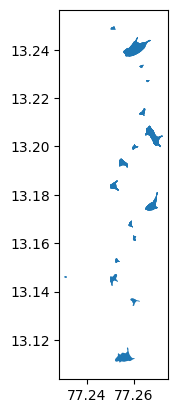

In [91]:
hydro_areas = gpd.read_file("./bangalore_hydrographical_areas.geojson")
hydro_areas.plot()

We may additionally plot these features on a map with Folium/Leaflet.

In [94]:
map = folium.Map(location=[12.960522, 77.597981], zoom_start=10)

for l in resources:
    folium.GeoJson(l["name"]+ ".geojson", tooltip=folium.GeoJsonTooltip(fields=['f_name']), name=l["name"]
                  ).add_to(map)
folium.LayerControl().add_to(map)
map